# Derivative Analytics Library

In [165]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
%matplotlib inline

## Background Environment Setup

In [166]:
def get_YearDelta(date, day_count=365):
    # return a ndarray contains day deltas in year
    # Parameter:
    '''
    date(array): array of datetime
    day_count(float): number of days for a year
    '''
    YearDelta = [(x-date[0]).days/day_count for x in date]
    return np.array(YearDelta)

In [167]:
# test get_YearDelta function with 2016/1/1, 2016/4/1, 2016/7/1, 2016/10/1
date = [dt.datetime(2016,1,1),dt.datetime(2016,4,1),dt.datetime(2016,7,1),dt.datetime(2016,10,1)]
get_YearDelta(date)

array([ 0.        ,  0.24931507,  0.49863014,  0.75068493])

### Short Curve Class

In [168]:
class const_rate(object):
    # a const_rate class 
    # attribute:
    '''
    name (string): name of the instance
    short_rate (float): the constant short rate
    '''
    # method:
    '''
    get_discount_factor(date, dttype=True): get array of time as input and 
                                            return 2 dimensional discount factor along with time
    '''
    
    def __init__(self, name, short_rate):
        # default initialization
        self.name=name
        self.short_rate=short_rate
        
    def get_discount_factor(self, date, dttype=True):
        # return an 2 dimensional array of discount factor along with day deltas in a row
        if dttype is True:  # if date input was in datetime format
            dlist=get_YearDelta(date)
        else:               # if date input was already in day delta format
            dlist=date
        dflist = np.exp(self.short_rate*np.sort(-dlist))   # assume countinuos compunding
        return np.array((date,dflist)).T       

In [169]:
# Test the const_rate class
conrate = const_rate('conrate', 0.05)
conrate.get_discount_factor(date)

array([[datetime.datetime(2016, 1, 1, 0, 0), 0.96316143217545],
       [datetime.datetime(2016, 4, 1, 0, 0), 0.9753767163648953],
       [datetime.datetime(2016, 7, 1, 0, 0), 0.9876116222305686],
       [datetime.datetime(2016, 10, 1, 0, 0), 1.0]], dtype=object)

In [170]:
class nonconst_rate(object):
    # a nonconst_rate class takes two sequence as rate and time
    # attribute:
    '''
    name (string): name of the instance
    short_rate (ndarray): the array of short rate 
    date (ndarray): the array of the date
    '''
    # method:
    '''
    get_discount_factor(dttype): return 2 dimensional discount curve along with time
    get_interp_graph(): return curve plot based on cubic spline interpolation
    '''
    def __init__(self, name, short_rate, date):
        # default initialization
        self.name=name
        self.short_rate=short_rate
        self.date = date
    
    def get_discount_factor(self,
                            dttype=True):
        if dttype is True:
            dlist = get_YearDelta(self.date)
        else:
            dlist = np.array(self.date)
        dflist = np.exp(self.short_rate*np.sort(-dlist))
        return np.array((date,dflist)).T   
    
    def get_interp_graph(self):
        time = get_YearDelta(self.date)
        rate = self.short_rate
        f = interp1d(time,rate,kind = 'cubic')
        xnew = np.linspace(0.,np.max(time), num=40, endpoint=True)
        fig = plt.plot(xnew,f(xnew),'-',linewidth=0.5)
        plt.plot(time,rate,'ro')
        plt.plot(time,rate,'--',linewidth=0.5)
        plt.legend(['cubic','data'],loc='best')
        return fig

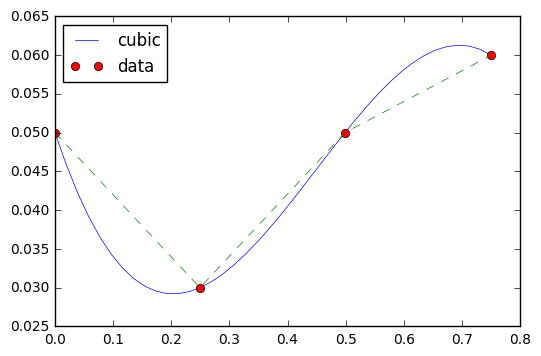

In [171]:
# Test the nonconst_rate class
short = np.array([0.05,0.03,0.05,0.06])
rate = nonconst_rate('rate',short, date)
rate.get_discount_factor()
fig = rate.get_interp_graph()

### Market Environment 

In [172]:
class mar_env(object):
    # a class holder for relative market environment 
    # attributes:
    '''
    name (string): object name
    pricing_date (datetime): date of the market environment
    constants (dictionary): model parameter such as volatility, risk free rate, etc. It can be a single object or an array
    lists (dictionary): list of risky securities, such as stock etc
    curves (dictionary): used to hold discounting cruve
    '''
    # methods:
    '''
    add_constants(key, constant), get_constants(key) : add and get element stored in dic according to key
    add_lists(key, lists), get_lists(key) : add and get element stored in dic according to key
    add_curves(key, curves), get_curves(key) : add and get element stored in dic according to key
    add_env(): add abovementioned elements in the dictionary
    print_env(): print information contained in the instance
    '''
    def __init__(self, name, price_date):
        self.name = name
        self.price_date = price_date
        self.constants={}
        self.lists={}
        self.curves={}
        
    def add_constants(self,key,constant):
        # constats as an attribute can be used to hold constant parameters.
        self.constants[key] = constant    
    def get_constants(self,key):
        return self.constants[key]
    
    def add_lists(self, key, list_object):
        # lists as an attribute can be used to hold securities.
        self.lists[key] = list_object        
    def get_lists(self, key):
        return self.lists[key]
    
    def add_curves(self, key, curve):
        # curves as an attribute can be used to hold short rate object.
        self.curves[key] = curve        
    def get_curves(self,key):
        return self.curves[key]
    
    def add_env(self, env):
        for key in env.constants:
            self.constants[key] = env.constants[key]
        for key in env.lists:
            self.lists[key] = env.lists[key]
        for key in env.curves:
            self.curves[key] = env.curves[key]
    
    def print_env(self):
        # print out all relevant market environment information
        print(self.name, '(Price Date: ', self.price_date, ')\n')
        print('constants:')
        print(self.constants, '\n')
        print('lists: ')
        print(self.lists, '\n')
        print('curves: ')
        print(self.curves)
        

In [173]:
# test market objects
market1 = mar_env('market1', dt.datetime(2015,1,1))
market1.add_lists('symbols', ['AAPL','MSFT','FB'])
market1.add_lists('symbols2',['NFLX','MS','GS'])
market1.add_curves('short_rate',rate)
market1.add_constants('volatility',0.3)
market1.add_constants('riskfree', 0)
market1.print_env()

market1 (Price Date:  2015-01-01 00:00:00 )

constants:
{'volatility': 0.3, 'riskfree': 0} 

lists: 
{'symbols': ['AAPL', 'MSFT', 'FB'], 'symbols2': ['NFLX', 'MS', 'GS']} 

curves: 
{'short_rate': <__main__.nonconst_rate object at 0x116923f98>}


## Simulation

In [174]:
def sn_generator(dim, antithetic = True, moment_matching = True, fixed_seed = False):
    # Used to generate random number with input dimension
    # Return standard normal random variables in desired dimension and shpes
    # 2 variane reduction (antithetic, moment_matching) method provided with Boolean variable
    # Parameters:
    '''
    dim (tuple): 3 dim tuple that defines the dimension of the random number
    antithetic: True if antithetic variance deduction method is applied
    moment_matching: True if moment_matchign variance deduction method is applied
    '''
    if fixed_seed is True:
        np.random.seed(10)
    if antithetic is True:
        rn = np.random.standard_normal((dim[0],dim[1],dim[2]/2))
        rn = np.concatenate((rn,-rn),axis=2)  # apply antithetic method
    else:
        rn = np.random.standard_normal(dim)
    if moment_matching is True:
        rn = rn-np.mean(rn)
        rn = rn/np.std(rn)   # apply moment matching method
    if dim[0] ==1:
        return rn[0]
    else:
        return rn

In [175]:
# Test sn_generator
snrn = sn_generator((3,4,4),antithetic=False,moment_matching=False,fixed_seed=True)
print('random number generated: ')
print(snrn)
print('mean: ', snrn.mean())
print('std: ', snrn.std())

random number generated: 
[[[ 1.3315865   0.71527897 -1.54540029 -0.00838385]
  [ 0.62133597 -0.72008556  0.26551159  0.10854853]
  [ 0.00429143 -0.17460021  0.43302619  1.20303737]
  [-0.96506567  1.02827408  0.22863013  0.44513761]]

 [[-1.13660221  0.13513688  1.484537   -1.07980489]
  [-1.97772828 -1.7433723   0.26607016  2.38496733]
  [ 1.12369125  1.67262221  0.09914922  1.39799638]
  [-0.27124799  0.61320418 -0.26731719 -0.54930901]]

 [[ 0.1327083  -0.47614201  1.30847308  0.19501328]
  [ 0.40020999 -0.33763234  1.25647226 -0.7319695 ]
  [ 0.66023155 -0.35087189 -0.93943336 -0.48933722]
  [-0.80459114 -0.21269764 -0.33914025  0.31216994]]]
mean:  0.0980537207591
std:  0.916390229175


### Generic Simulation Class

In [176]:
class simulation_class(object):
    # generic class for simulation methods
    # define the format and output for all simulation methods
    # attributes:
    '''
    name (string): class name
    mar_env (object): instance of market_environment
    corr (boolean): True if correlated with other model object
    '''
    # parameter requirement:
    '''
    Madatory parameter that should be passed from the mar_env class:
     price date, 
     from constants attribute: final_date, frequency, volatility, initial_value, paths
     from curves attribuet: discoung_curve
     
    Optional parameter that should be passed from the mar_env class:
     from lists attribute: 
        time_grid, cholesky_matrix, rn_set, random_nember
     
    '''
    # methods:
    '''
    time_grid_generator(): generate a time grid contained in ndarray
    get_instrumetn_values(): call the generate_paths method in sub class
    get_hist(): provide histogram for the simulated final values
    '''
    def __init__(self, name, mar_env, corr=False):
        try: # use try for information parse check and provide relavant error information
            self.name = name
            self.price_date = mar_env.price_date
            self.final_date = mar_env.get_constants('final_date')
            self.frequency = mar_env.get_constants('frequency')
            self.volatility = mar_env.get_constants('volatility')
            self.initial_value = mar_env.get_constants('initial_value')
            self.discount_curve = mar_env.get_curves('discount_curve')
            self.paths =  mar_env.get_constants('paths')
            self.correlated = corr
            if corr is True:  # if this simulation is correlated with other simulation
                              # then cholesky decompositon was used to generate correlated 
                              # random number
                self.cholesky_matrix = mar_env.get_lists('cholesky_matrix')
                self.rn_set = mar_env.get_lists('rn_set')[self.name]   
                self.random_numbers = mar_env.get_lists('random_numbers')
            try:
                self.time_grid = mar_env.get_lists('time_grid')
            except:
                self.time_grid=None
        except:
            print('Necessary information missing')
    
    def time_grid_generator(self):
        # it generate a equally intervaled time grid for simulation.
        # one thing should be noted is that it this function didn't return anything
        start = self.price_date
        end = self.final_date
        time_grid=pd.date_range(start=start, end=end,freq=self.frequency).to_pydatetime()
        if start not in time_grid:
            time_grid=np.insert(time_grid,0,start)
        if end not in time_grid:
            time_grid = np.insert(time_grid,-1,end)
        time_grid=list(time_grid)
        self.time_grid = np.array(time_grid)
    
    
    def get_instrument_values(self, fixed_seed = True):
        self.generate_paths(fixed_seed = fixed_seed, day_count=365)
        return self.instrument_values     
    
    def get_hist(self):
        plt.hist(self.instrument_values[-1],bins=50)
        plt.xlabel('final value')
        plt.ylabel('frequency')
        plt.grid(True)
        plt.title('Final value for simulation')

### Geometric Brownian Motion

In [177]:
class geometric_brownian_motion(simulation_class):
    # a sub clas inheritated from the simulaiton_class
    # attribute:
    '''
    name (string): name of the object
    mar_env(object): instantce of market environment
    corr (Boolean): wheter correlated with other simulation
    '''
    # method:
    '''
    generate_pahts: take stored information and generated underlying asset paths
    
    '''
    def __init__(self, name, mar_env,corr=False):
        # No additional information needed other than information from simulation_class
        super(geometric_brownian_motion, self).__init__(name, mar_env, corr)
    
    def update(self, initial_value=None, volatility=None, final_date=None, price_date = None):
        # update the main attribute for the GBM simulation
        if initial_value is not None:
            self.initial_value = initial_value
        if volatility is not None:
            self.volatility = volatility
        if final_date is not None:
            self.final_date = final_date
        if price_date is not None:
            self.price_date = price_date
        self.instrument_value=None
    
    def generate_paths(self, fixed_seed = False, day_count=365.):
        if self.time_grid is None:
            self.time_grid_generator()
        M = len(self.time_grid)  # time interval
        N = self.paths           # number of simulation path
        paths = np.zeros((M,N))
        paths[0] = self.initial_value
        if not self.correlated:
            rand = sn_generator((1,M,N),fixed_seed=fixed_seed)
        else:
            rand = self.random_numbers
        shor_rate = self.discount_curve.short_rate
        for t in range(1, len(self.time_grid)):
            if not self.correlated:
                ran = rand[t]
            else:
                ran = np.dot(self.cholesky_matrix, rand[:,t,:])
                ran = ran[self.rn_set]
            dt = (self.time_grid[t]-self.time_grid[t-1]).days/day_count
            paths[t] = paths[t-1]*np.exp((self.discount_curve.short_rate - 0.5*self.volatility**2)*dt+self.volatility*np.sqrt(dt)*ran)
        self.instrument_values = paths    

(array([ 735964.,  735995.,  736024.,  736055.,  736085.,  736116.,
         736146.,  736177.,  736208.,  736238.,  736269.,  736299.]),
 <a list of 12 Text xticklabel objects>)

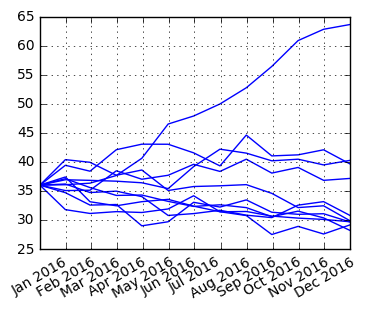

In [178]:
# Test GBM simulation
market_env = mar_env('market_env',dt.datetime(2016,1,1))
market_env.add_constants('initial_value', 36.)
market_env.add_constants('volatility',0.2)
market_env.add_constants('final_date', dt.datetime(2016,12,31))
market_env.add_constants('frequency','M')
market_env.add_constants('paths', 10000)
csr = const_rate('csr', 0.05)
market_env.add_curves('discount_curve', csr)
gbm = geometric_brownian_motion('gbm', market_env)
gbm.time_grid_generator()
paths1 = gbm.get_instrument_values()
plt.figure(figsize=(4,3))
plt.plot(gbm.time_grid,paths1[:, :10],'b')
plt.grid(True)
plt.xticks(rotation=30)

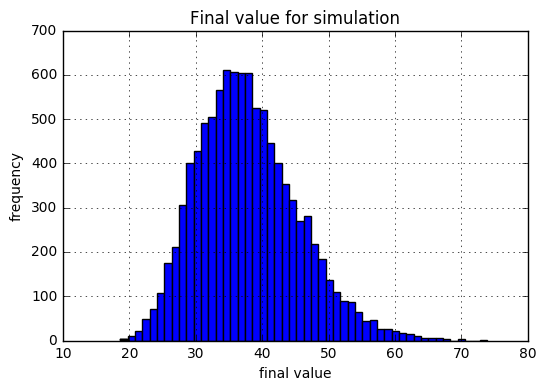

In [179]:
gbm.get_hist()

### Jump Diffusion

In [180]:
class jump_diffusion(simulation_class):
    # class for jump difussion paths
    # attributes:
    '''
    name(string): name of the class
    mar_env(object): instance of market environment
    corr(Boolean): True if correlated with other model object
    '''
    # methods:
    '''
    update: update parameters and clean previous simulation
    generate_paths: generate paths
    '''
    def __init__(self, name, mar_env, corr=False):
        super(jump_diffusion,self).__init__(name,mar_env,corr)
        # compulsary parameters:
        try:
            self.lamb = mar_env.get_constants('lambda')
            self.mu = mar_env.get_constants('mu')
            self.delt = mar_env.get_constants('delta')
        except:
            print('One or more of lambda, mu, or delta are missing ')
    
    def update(self, initial_value=None, volatility=None,lamb=None,mu=None,delta=None,final_date=None):
        # update class parameters and clean previous simulation
        if initial_value is not None:
            self.initial_value = initial_value
        if volatility is not None:
            self.volatility = volatility
        if lamb is not None:
            self.lamb = lamb
        if mu is not None:
            self.mu=mu
        if delta is not None:
            self.delt = delta
        if final_date is not None:
            self.final_date = final_date
        self.instrument_values = None
        
    def generate_paths(self, fixed_seed=False, day_count=365.):
        # generate Monte Carlo paths for underlying asset
        if self.time_grid == None:
            self.time_grid_generator()
        M = len(self.time_grid)
        N = self.paths
        paths = np.zeros((M,N))
        paths[0] = self.initial_value
        if self.correlated is False:
            sn1 = sn_generator((1,M,N),fixed_seed=fixed_seed)
        else:
            sn1 = self.random_numbers
        # jump component:
        sn2 = sn_generator((1,M,N),fixed_seed=fixed_seed)
        rj = self.lamb*(np.exp(self.mu+0.5*self.delt**2)-1)
        short_rate = self.discount_curve.short_rate
        for t in range(1, len(self.time_grid)):
            if self.correlated is False:
                ran=sn1[t]
            else:
                ran=np.dot(self.cholesky_matrix,sn1[:,t,:])
                ran=ran[self.rn_set]
            dt=(self.time_grid[t]-self.time_grid[t-1]).days/day_count
            poi = np.random.poisson(self.lamb*dt,N)
            paths[t] = paths[t-1]*(np.exp((short_rate-rj-0.5*self.volatility**2)*dt
                                         +self.volatility*np.sqrt(dt)*ran)+(np.exp(self.mu+self.delt*
                                                                                  sn2[t])-1)*poi)
        self.instrument_values = paths   

In [181]:
# test jump diffusion simulation
jd = mar_env('jd',dt.datetime(2016,1,1))
jd.add_constants('lambda',0.3)
jd.add_constants('mu',-0.75)
jd.add_constants('delta',0.1)
jd.add_env(market_env)
jd_simu=jump_diffusion('jd_simu',jd)
jd_simu.get_instrument_values()

array([[ 36.        ,  36.        ,  36.        , ...,  36.        ,
         36.        ,  36.        ],
       [ 37.89031941,  36.66575773,  37.40746793, ...,  35.22629779,
         34.02769695,  34.19953617],
       [ 33.99559832,  35.62257998,  37.77148613, ...,  34.24210501,
         36.53593802,  33.15140475],
       ..., 
       [ 32.95603923,  17.03377127,  46.13566342, ...,  38.65116653,
         40.66702322,  22.47702741],
       [ 31.87121485,  17.57624842,  45.60310339, ...,  36.44146181,
         43.52549491,  21.12758137],
       [ 34.13142408,  16.53996019,  47.13130627, ...,  38.92971837,
         46.30968502,  19.40713924]])

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:42: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


(array([ 735964.,  735995.,  736024.,  736055.,  736085.,  736116.,
         736146.,  736177.,  736208.,  736238.,  736269.,  736299.]),
 <a list of 12 Text xticklabel objects>)

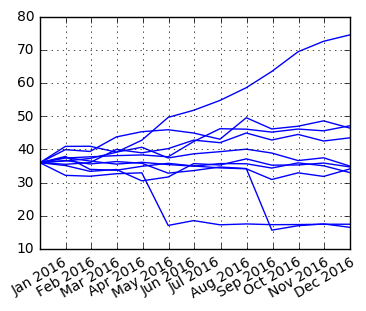

In [182]:
paths2 = jd_simu.get_instrument_values()
plt.figure(figsize=(4,3))
plt.plot(jd_simu.time_grid,paths2[:, :10],'b')
plt.grid(True)
plt.xticks(rotation=30)

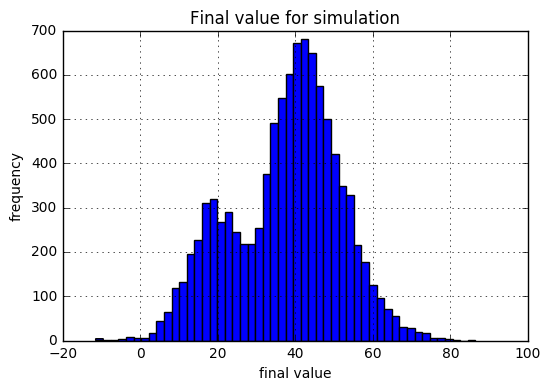

In [183]:
jd_simu.get_hist()

### Mean Reverting (CIR)

In [184]:
class cir(simulation_class):
    # class for jump difussion paths
    # attributes:
    '''
    name(string): name of the class
    mar_env(object): instance of market environment
    corr(Boolean): True if correlated with other model object
    '''
    # methods:
    '''
    update: update parameters and clean previous simulation
    generate_paths: generate paths
    '''
    def __init__(self, name, mar_env, corr=False):
        super(cir,self).__init__(name,mar_env, corr)
        try:
            self.kappa = mar_env.get_constants('kappa')
            self.theta = mar_env.get_constants('theta')
        except:
            print('One or more of kapap and theta is missing')
    
    def update(self,initial_value=None, volatility=None, kappa=None,
              theta=None,final_date = None):
        # update class parameters and clean previous simulation results
        if initial_value is not None:
            self.initial_value = initial_value
        if volatility is not None:
            self.volatility = volatility
        if kappa is not None:
            self.kappa = kappa
        if theta is not None:
            self.theta = theta
        if final_date is not None:
            self.final_date = final_date
        self.instrument_values = None
    
    def generate_paths(self, fixed_seed=True, day_count=365.):
        if self.time_grid is None:
            self.time_grid_generator()
        M = len(self.time_grid)
        N = self.paths
        paths=np.zeros((M,N))
        paths2=np.zeros((M,N))
        paths[0] = self.initial_value
        paths2[0] = self.initial_value
        if self.correlated is False:
            rand = sn_generator((1,M,N),fixed_seed=fixed_seed)
        else:
            rand = self.random_numbers
        for t in range(1, len(self.time_grid)):
            dt = (self.time_grid[t]-self.time_grid[t-1]).days/day_count
            if self.correlated is False:
                ran = rand[t]
            else:
                ran=np.dot(self.cholesky_matrix, rand[:,t,:])
                ran=ran[self.rn_set]
            paths2[t] = (paths2[t-1]+self.kappa*(self.theta-np.maximum(0,paths2[t-1,:]))*dt
                        +np.sqrt(np.maximum(0,paths2[t-1,:]))
                        *self.volatility*np.sqrt(dt)*ran)
            paths[t] = np.maximum(0,paths2[t])
        self.instrument_values = paths

In [185]:
# Test CIR process
CIR_env = mar_env('CIR_env',dt.datetime(2016,1,1))
CIR_env.add_constants('initial_value',0.25)
CIR_env.add_constants('volatility',0.1)
CIR_env.add_constants('final_date',dt.datetime(2016,12,31))
CIR_env.add_constants('frequency', 'W')
CIR_env.add_constants('paths',10000)
CIR_env.add_constants('kappa',3)
CIR_env.add_constants('theta',0.3)
CIR_env.add_curves('discount_curve',const_rate('r',0.1))
CIR_simu = cir('CIR_simu',CIR_env)
CIR_paths = CIR_simu.get_instrument_values()[:,:10]

(array([ 735964.,  735995.,  736024.,  736055.,  736085.,  736116.,
         736146.,  736177.,  736208.,  736238.,  736269.,  736299.]),
 <a list of 12 Text xticklabel objects>)

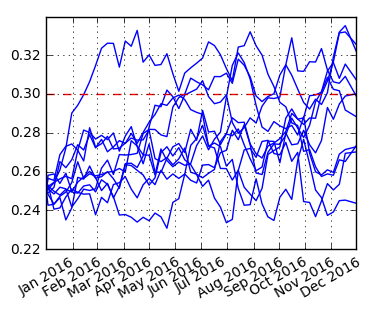

In [189]:
plt.figure(figsize=(4,3))
plt.plot(CIR_simu.time_grid,CIR_paths[:, :10],'b')
plt.axhline(CIR_simu.theta,color='r',ls='--')
plt.grid(True)
plt.xticks(rotation=30)

## Derivative Valuation

### Generic Valuation Class

In [16]:
class valuation_class(object):
    # generic class for single factor valuation model
    # attribtue:
    '''
    name (string): name of the object
    underlying (object): instance of simulation class
    mar_env (object): instance of market environment
    payoff_func(string): payoff function at maturity
    '''
    '''
    mandatory parameter should inherited from mar_env:
     from constant: maturity
     from attribute: maturity date, frequency, discount_curve
    optional parameter:
     strike (only for option)
    '''
    # method
    
    def __init__(self, name, underlying, mar_env, payoff_func=''):
        try:
            self.name=name
            self.price_date = mar_env.price_date
            self.maturity=mar_env.get_constants('maturity')
            self.frequency=underlying.frequency
            self.paths = underlying.paths
            self.discount_curve = underlying.discount_curve
            self.payoff_func = payoff_func
            self.underlying = underlying
            try:
                self.strike=mar_env.get_constants('strike')
            except:
                pass
        except:
            print('Extra necessary information needed')
            
    def update(self, initial_value=None, volatility=None, strike = None, maturity=None):
        if initial_value is not None:
            self.underlying.update(initial_value = initial_value)
        if volatility is not None:
            self.underlying.update(volatility = volatility)
        if strike is not None:
            self.strike = strike
        if maturity is not None:
            self.maturity = maturity
            if not maturity in self.underlying.time_grid:
                self.underlying.special_dates.append(maturity)
        self.underlying.instrument_values = None
        
        
    def delta(self,interval=None):
        if interval is None:
            interval = self.underlying.initial_value/50.
        value_left=self.present_value(fixed_seed=True)
        initial_del = self.underlying.initial_value+interval
        self.underlying.update(initial_value=initial_del)
        value_right = self.present_value(fixed_seed=True)
        self.underlying.update(initial_value=initial_del-interval)
        delta = (value_right-value_left)/interval
        return delta
    
    def vega(self,interval=0.01):
        if interval < self.underlying.volatility/50.:
            interval=self.underlying.volatility/50.
        value_left=self.present_value(fixed_seed=True)
        vola_del=self.underlying.volatility+interval
        self.underlying.update(volatility=vola_del)
        value_right=self.present_value(fixed_seed=True)
        self.underlying.update(volatility=vola_del-interval)
        vega = (value_right-value_left)/interval
        return vega  

### European Option with Monte Carlo Simulation

In [17]:
class valuation_mcs_euro(valuation_class):
    # one factor monte-carlo simulation valuation
    def generate_payoff(self,fixed_seed=False):
        try:
            strike=self.strike
        except:
            pass
        paths = self.underlying.get_instrument_values(fixed_seed=fixed_seed)
        time_grid = self.underlying.time_grid
        try:
            time_index = np.where(time_grid ==self.maturity)[0]
            time_index = int(time_index)
        except:
            print('Maturity should be in the time grid')
        maturity_value = paths[time_index]
        mean_value=np.mean(paths[:time_index],axis=1)
        max_value=np.amax(paths[:time_index],axis=1)[-1]
        max_value=np.amax(paths[:time_index],axis=1)[-1]
        try:
            payoff = eval(self.payoff_func)
            return payoff
        except:
            print('Payoff function error')
    
    def present_value(self, accuracy=6,fixed_seed=False, full = False):
        cash_flow = self.generate_payoff(fixed_seed=fixed_seed)
        discount_factor = self.discount_curve.get_discount_factor((self.price_date,self.maturity))[0,1]
        result = discount_factor*np.sum(cash_flow)/len(cash_flow)
        if full:
            return result, discount_factor*cash_flow
        else:
            return result

In [18]:
# Test
mar_env.add_constants('strike', 40.)
mar_env.add_constants('maturity', dt.datetime(2016,12,31))
payoff_func='np.maximum(maturity_value-strike,0)'
euro_call = valuation_mcs_euro('euro_call', underlying = gbm, mar_env=mar_env, payoff_func=payoff_func)
%time print('option value: ', euro_call.present_value())
%time print('delta: ', euro_call.delta())
%time print('veta: ', euro_call.vega())


option value:  2.08391070036
CPU times: user 6.64 ms, sys: 1.72 ms, total: 8.36 ms
Wall time: 7.65 ms
delta:  0.44829805635
CPU times: user 21.9 ms, sys: 1.64 ms, total: 23.5 ms
Wall time: 42.2 ms
veta:  14.0693749699
CPU times: user 21.8 ms, sys: 902 µs, total: 22.7 ms
Wall time: 37.2 ms


### American Option with Longstaff & Schwartz

In [19]:
class longstaff_schwartz(valuation_class):
    # Can be used for both American and Bermudan option
    # inherited information form valuation_class
    # method:
    def generate_payoff(self, fixed_seed = False):
        try:
            strike = self.strike
        except:
            print('no strike price')
        paths = self.underlying.get_instrument_values(fixed_seed=fixed_seed)
        time_grid = self.underlying.time_grid       
        time_index_start = np.where(time_grid==self.price_date)[0]
        time_index_start = int(time_index_start)
        time_index_end = np.where(time_grid==self.maturity)[0]
        time_index_end = int(time_index_end)
        instrument_values = paths[time_index_start:time_index_end+1]
        try:
            payoff = eval(self.payoff_func)
            return instrument_values, payoff, time_index_start, time_index_end
        except:
            print('Error in evaluation payoff function')
            
    
    def present_value(self, fixed_seed=False, bf = 4, full=False):
        # return option value
        # parameters:
        '''
        bf (int): basis function choice
        full (Boolean): return full array of values or a single option value
        '''
        
        instrument_values, inner_values,time_start, time_end = self.generate_payoff(fixed_seed = fixed_seed)
        time_list=self.underlying.time_grid[time_start:time_end+1]
        discount_factors=self.discount_curve.get_discount_factor(time_list, dttype=True)
        v = inner_values[-1]
        for t in range(len(time_list)-2,0,-1):
            df = discount_factors[t,1]/discount_factors[t+1,1]
            reg = np.polyfit(instrument_values[t],v*df, bf)
            c = np.polyval(reg, instrument_values[t])
            v = np.where(inner_values[t]>c, inner_values[t], v*df)
        df = discount_factors[0,1]/discount_factors[1,1]
        result = df*np.sum(v)/len(v)
        if full:
            return result, df*v
        else:
            return result

In [20]:
# Test
payoff_func = 'np.maximum(strike-instrument_values, 0)'
Ameri_Put = longstaff_schwartz('Ameri_Put', underlying = gbm, mar_env=mar_env, payoff_func=payoff_func)
% time print('Basis function of 4: ', Ameri_Put.present_value(fixed_seed=True, bf=4))
% time print('Basis function of 5: ', Ameri_Put.present_value(fixed_seed=True, bf=5))

Basis function of 4:  4.56824125778
CPU times: user 51.4 ms, sys: 3.27 ms, total: 54.6 ms
Wall time: 81.9 ms
Basis function of 5:  4.5791461387
CPU times: user 44.7 ms, sys: 2.19 ms, total: 46.9 ms
Wall time: 51.4 ms


## Portfolio

### Generic Portfolio class

In [21]:
class derivative_position(object):
    # class that hold derivative position
    # attribute:
    '''
    name(string): name of the positon
    quantity (float): number of derivatives
    underlying (string): name of asset for derivative
    mar_env (object): instantce of market environment
    otype (string): valuation method to use
    payoff_func (string): payoff function in string format
    '''
    
    # method:
    
    def __init__(self, name, quantity, underlying, mar_env, otype, payoff_func):
        self.name = name
        self.quantity = quantity
        self.underlying = underlying
        self.mar_env = mar_env
        self.otype = otype
        self.payoff_func = payoff_func
        
        
    def print_info(self):
        print('Name: ', self.name, '\n')
        print('Quantity: ', self.quantity)
        print('Underlying: ', self.underlying)
        self.mar_env.print_env()
        print('Derivative Type: ', self.otype)
        print('Payoff Function: ', self.payoff_func)
        
    

In [22]:
dev_po = derivative_position(name = 'dev_po',
                            quantity = 1,
                            underlying = 'gbm',
                            mar_env = mar_env,
                            otype='European',
                            payoff_func=payoff_func)

In [23]:
dev_po.print_info()

Name:  dev_po 

Quantity:  1
Underlying:  gbm
mar_env (Price Date:  2016-01-01 00:00:00 )

constants:
{'strike': 40.0, 'initial_value': 36.0, 'paths': 10000, 'frequency': 'M', 'volatility': 0.2, 'maturity': datetime.datetime(2016, 12, 31, 0, 0), 'final_date': datetime.datetime(2016, 12, 31, 0, 0)} 

lists: 
{} 

curves: 
{'discount_curve': <__main__.const_rate object at 0x1073414e0>}
Derivative Type:  European
Payoff Function:  np.maximum(strike-instrument_values, 0)


In [24]:
class derivative_position(object):
    # class for derivative portfolio analysis
    # attribtue:
    '''
    name (string): name of the portfolio
    positions (dic): a dictionary of derivative and quantity
    mar_env (object): instance of market environment
    assets (dic): dictionary of market environments for assets
    correlation (list): correlation between lists
    fixed_seed (Boolean): true if use fixed random number
    '''
    # method
    
    def __init__(self, name, positions, env, assets, correlations = None, fixed_seed = False):
        self.name = name
        self.positions = positions
        self.env = env
        self.assets = assets
        self.underlyings = set()
        sefl.correlations = correlations
        self.time_grid = None
        self.underlying_objects = {}
        self.valuation_objects = {}
        self.fixed_seed = fixed_seed
        self.special_dates = []
        for p in self.positions:
            self.env.constants['starting_date'] = min(self.env.constants['starting_date'],positions[p].mar_env.price_date)
            self.env.constants['final_date'] = max(self.mar_env.constants['final_date'],positions[p].mar_env.constants['maturity'])
            self.underlyings.add(positions[p].underlying)
        start = self.env.constants['starting_date']
        end = self.env.constants['final_date']
        time_grid = pd.date_range(start=start,end=end,freq=self.env.constants['frequency']).to_pydatetime()
        time_grid=list(time_grid)
        for p in self.positions:
            maturity_date = positions[p].mar_env.constants['maturity']
            if maturity_date not in time_grid:
                time_grid = np.insert(time_grid,0,maturity_date)
                self.special_dates.append(maturity_date)
        if start not in time_grid:
            time_grid=np.insert(time_grid,0,start)
        if end not in time_grid:
            time_grid.append(end)
        time_grid = list(set(time_grid))
        time_grid.sort()
        self.time_grid=np.array(time_grid)
        self.env.add_list('time_grid', self.time_grid)
        if correlations is not None:
            ul_list=sorted(self.underlyings)
            correlation_matrix=np.zeros((len(ul_list),len(ul_list)))
            np.fill_diagonal(correlation_matrix, 1.0)
            correlation_matrix = pd.DataFrame(correlation_matrix, index=ul_list,columns=ul_list)
            for i, j, corr in correlations:
                corr = min(corr,1.0)
                correlation_matrix.loc[i,j] = corr
                correlation_matrix.loc[j,i] = corr
            cholesky_matrix = np.linalg.cholesky(np.array(correlation_matrix))
            rn_set={asset:ul_list.index(asset) for asset in self.underlyings}
            random_numbers = sn_random_numbers((len(rn_set),len(self.time_grid),self.env.constants['paths']),fixed_seed = self.fixed_seed)
            self.env.add_list('cholesky_matrix', cholesky_matrix)
            self.env.add_list('random_numbers',random_numbers)
            slef.env.add_list('rn_set',rn_set)
            
        for asset in self.underlyings:
            mar_env = self.assets[asset]
            mar_env.add_environment(env)
            model = models[mar_env.constants['model']]
            if correlations is not None:
                self.underlying_objects[asset] = model(asset, mar_env, corr=True)
            else:
                self.underlying_objects[asset] = model(asset, mar_env, corr=False)
        
        for p in positions:
            val_class=otyp[positions[p].otype]
            mar_env = positions[p].mar_env
            mar_env.add_environment(self.env)
            self.valuation_objects[p] = val_class(name=positions[p].name, mar_env=mar_env,
                                                 underlying=self.underlying_objects[positions[p].underlying],
                                                 payoff_func = positions[p].payoff_func)
            
    
    def get_positions(self):
        for p in self.positions:
            bar = '\n'+50*'-'
            print(bar)
            self.positions[p].print_info()
            print(bar)
            
    
    def get_statistics(self, fixed_seed=False):
        res_list=[]
        for pos, value in self.valuation_objects.items():
            p = self.positions[pos]
            pv = value.present_value(fixed_seed = fixed_seed)
            res_list.append([
                    p.name,
                    p.quantity,
                    pv,
                    pv*p.quantity,
                    value.delta()*p.quantity,
                    value.vega()*p.quantity
                ])
        res_df=pd.DataFrame(res_list,columns=['name','quant.','value','curr.','pos_value','pos_delta','pos_vega'])
        return res_df

In [25]:
models ={'gbm':geometric_brownian_motion}
otypes={'European':valuation_mcs_euro,
       'American': longstaff_schwartz}

In [27]:
me_jd = mar_env('me_jd', dt.datetime(2015,1,1))

TypeError: 'mar_env' object is not callable

In [ ]:
me_euro_call = mar_env('me_euro_call', dt.datetime(2015,1,1))

In [ ]:
me_euro_call.add_constants('maturity', dt.datetime(2016,6,30))
me_euro_call.add_constants('strike',38.)
payoff_func='np.maximum(maturity_value-strike,0)'

In [ ]:
euro_call_pos = derivative_position(name='euro_call_pos',
                                   quantity=5,
                                   underlying='gbm',
                                   mar_env=me_euro_call,
                                   otype='European',
                                   payoff_func=payoff_func)

In [ ]:
underlyings = {'gbm':}